In [1]:
import os

os.environ["MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR"] = "false"

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
from collections import Counter
from torch.utils.data import Subset, SubsetRandomSampler, DataLoader
import mlflow
from mlflow import MlflowClient

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
import src.d02_binary_model

"""
from torchvision.datasets import ImageFolder
from torch.optim import Adam
from torch.amp import autocast, GradScaler
import numpy as np
from sklearn.metrics import accuracy_score
from torch.utils.data import ConcatDataset
"""
# import training_v1
from src.d02_binary_model import Trainer, CustomImageFolder

import tqdm

device = "cpu"

In [5]:
import torch
a = torch.tensor([[ 2.4048107 ,  5.0334096 ],
                    [-0.7921977 , -4.1523376 ],
                    [ 0.9447198 , -0.46802214],
                    [ 1.158121  ,  3.9810789 ],
                    [ 4.768706 ,   2.3220146 ],
                    [ 6.1481323 ,  3.909829  ]])
b = torch.tensor([[0., 1.],
                [0., 0.],
                [0., 0.],
                [0., 0.],
                [0., 0.],
                [1., 0.]])

torch.nn.functional.cross_entropy(a, b)

tensor(0.0285)

In [ ]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchvision.transforms.v2 as transforms
import random
import matplotlib.patches as patches


def gradcam(path, part, l_idx, img_idx=None, to_show=1):
    model_name = path.replace("/", "_") + "_" + part
    
    client = MlflowClient()
    model_version = client.search_model_versions(f'name="{model_name}"')[0].version
    
    model = mlflow.pytorch.load_model(f'models:/{model_name}/{model_version}').to('cpu') 
    model.eval()    

    img_channels = Trainer.get_img_shape(f"{path}/{part}")[0]
    transform = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ToDtype(torch.float32, scale=True),
            transforms.Normalize([0.5] * img_channels, [0.5] * img_channels),
        ]
    )

    ds = CustomImageFolder(path, transform=transform)
    ds = Subset(
        ds,
        [i for i, target in enumerate(ds.targets) if target == ds.class_to_idx[part]],
    )
    if img_idx is None:
        img_idx = random.randint(0, len(ds.indices) - 1)

    input_tensor = ds[img_idx][0].unsqueeze(0)

    img = ds[img_idx][0] * 0.5 + 0.5
    img = img.clamp(0, 1)

    if img_channels == 1:
        img = img.squeeze(0).numpy()  # shape (H, W)
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # shape (H, W, 3)
    else:
        img = img.permute(1, 2, 0).numpy()
    if True:
        #print(model.layers)
        target_layers = [model.layers.features[l_idx]]#[2]
        
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers)  
        targets = [ClassifierOutputTarget(0)]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  
    else:
        grayscale_cam = np.array(
            Image.open(
                f"D:/gradcam_imgs/{l_idx}/{path.replace('./data/temp/', '')}{part}/{img_idx}.jpg"
            )
        )
    grayscale_cam = grayscale_cam / (grayscale_cam.max()+1e-8)

    f, ax = plt.subplots(1, 3, figsize=(10, 5))  # (40, 20))
    ax[2].imshow(grayscale_cam, cmap="jet")
    try:
        top, bottom, left, right, grayscale_cam = get_boundary_box(
            grayscale_cam, 6, to_show
        )
        # print(grayscale_cam.shape, np.min(grayscale_cam), np.max(grayscale_cam))
    except ValueError:
        print("Image idx:", img_idx)
        raise
    # visualization = show_cam_on_image(img, grayscale_cam, use_rgb=False)

    # f, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[1].imshow(img)
    ax[0].imshow(grayscale_cam)  # , cmap='jet')
    # ax[1].hist(grayscale_cam.ravel(), 256)
    # ax[2].imshow(visualization, cmap='jet')

    for i in range(3):
        rect = patches.Rectangle(
            (left, top),
            right - left,
            bottom - top,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax[i].add_patch(rect)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

    plt.tight_layout()
    plt.show()

In [4]:
import cv2 as cv
import datetime
import math

def get_boundary_box(grayscale_cam, num, to_show=1):    
    box = {'bottom': 1,
           'top': -1,           
           'right': 1,
           'left': 0}
    
    #grayscale_cam[grayscale_cam < np.average(grayscale_cam)] = 0
    #grayscale_cam = cv.adaptiveThreshold(grayscale_cam,1,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,21,-4)
    #grayscale_cam = cv.adaptiveThreshold(grayscale_cam,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,-2)   

    if np.max(grayscale_cam) > 0:  
        cv.rectangle(grayscale_cam, (0,0), grayscale_cam.shape[::-1], 0, 32) 
        grayscale_cam = np.array(grayscale_cam * 255, dtype = np.uint8)
        #filtered_img = cv.adaptiveThreshold(grayscale_cam,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,31,-25)

        
        num_labels = 0
        threshold_c = -30#-31
        while num_labels < 2:
            if threshold_c > 10:
                return 1, 2, 1, 2, grayscale_cam
            
            #filtered_img = cv.adaptiveThreshold(grayscale_cam,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 25, threshold_c)
            filtered_img = cv.adaptiveThreshold(grayscale_cam,1,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 31, threshold_c)
            num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(filtered_img, connectivity=8)
            threshold_c += 1
            if num_labels < 2:
                print('th_c ', threshold_c)
        k=31
        kernel = np.ones((k,k), np.uint8)  # radius ~ 1 pixel
        #filtered_img = cv.dilate(filtered_img, kernel, iterations=1)
        #filtered_img = cv.erode(filtered_img, kernel, iterations=1)  # closing
        grayscale_cam[grayscale_cam < np.average(grayscale_cam)] = 0 
        
        #obj_lbl = np.argmax(stats[1:, cv.CC_STAT_AREA]) + 1

        h, w = filtered_img.shape
        img_center = np.array([w / 2, h / 2])

        obj_lbl = 1
        pow=2.5

        if len(stats) < 2:
            asdasd=3
        
        max_val = stats[1, cv.CC_STAT_AREA]/(math.dist(centroids[1], img_center)+1)**pow
        #print(max_val, stats[1, cv.CC_STAT_AREA], math.dist(centroids[1], img_center))

        for i in range(2, num_labels):  # skip background (label 0)
            if stats[i, cv.CC_STAT_AREA] > 50 and max_val < stats[i, cv.CC_STAT_AREA]/(math.dist(centroids[i], img_center)+1)**pow:
                max_val = stats[i, cv.CC_STAT_AREA]/(math.dist(centroids[i], img_center)+1)**pow
                #print(max_val, stats[i, cv.CC_STAT_AREA], math.dist(centroids[i], img_center))
                obj_lbl = i

            #if stats[i, cv.CC_STAT_AREA] > 50:
                #print(stats[i, cv.CC_STAT_AREA]/(math.dist(centroids[i], img_center)+1)**pow, stats[i, cv.CC_STAT_AREA], math.dist(centroids[i], img_center), centroids[i],img_center, "----")
            """
            if stats[i, cv.CC_STAT_AREA] == 432:
                obj_lbl = i
                max_val = float("inf")
            """

        box['top'] = int(centroids[obj_lbl][1])
        box['left'] = int(centroids[obj_lbl][0])
        box['bottom'] = box['top'] + 1
        box['right'] = box['left'] + 1
        
        step = {'top': -1,
                'bottom': 1,
                'left': -1,
                'right': 1}
        
        moves_on_equal = {'top': 0,
                'bottom': 0,
                'left': 0,
                'right': 0}
        
        max_vals = {}

        while True:
            for key in box:
                if key in ['top', 'bottom']:
                    if (0 <= box[key] + step[key] <= grayscale_cam.shape[0] - 1 and
                            (grayscale_cam.shape[0] // (box['bottom'] - box['top'] + 1)) * (grayscale_cam.shape[1] // (box['right'] - box['left'])) >= num): 
                        max_vals[key] = np.max(grayscale_cam[box[key] + step[key], box['left']:box['right']])
                    else:
                        max_vals[key] = -1
                else:
                    if (0 <= box[key] + step[key] <= grayscale_cam.shape[1] - 1 and
                            (grayscale_cam.shape[0] // (box['bottom'] - box['top'])) * (grayscale_cam.shape[1] // (box['right'] - box['left'] + 1)) >= num): 
                        max_vals[key] = np.max(grayscale_cam[box['top']:box['bottom'], box[key] + step[key]])
                    else:
                        max_vals[key] = -1
            
            max_val = max(max_vals.values())
            if max_val == -1:
                break
            max_val_keys = []

            for key in max_vals:
                if max_val == 0 == max_vals[key] or max_vals[key]/(max_val+1e-8) > 0.75:
                    max_val_keys.append(key)

            if len(max_val_keys) > 1:
                min_moves = float('inf')
                min_moves_key = ''
                for key in max_val_keys:
                    if moves_on_equal[key] < min_moves:
                        min_moves = moves_on_equal[key]
                        min_moves_key = key
                moves_on_equal[min_moves_key] += 1
                box[min_moves_key] += step[min_moves_key]
            else:
                #print(max_val)
                box[max_val_keys[0]] += step[max_val_keys[0]]  
            
        if to_show == 1:
            grayscale_cam = labels == obj_lbl  
        elif to_show == 2:
            grayscale_cam = filtered_img   
        elif to_show == 3:
            pass
    return box['top'], box['bottom'], box['left'], box['right'], grayscale_cam

./data/temp/wheels_five/scale_0.2/ screw
12 500


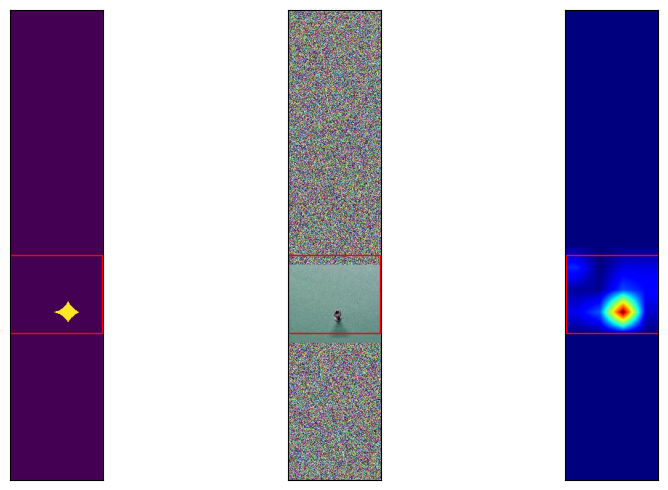

12 1000


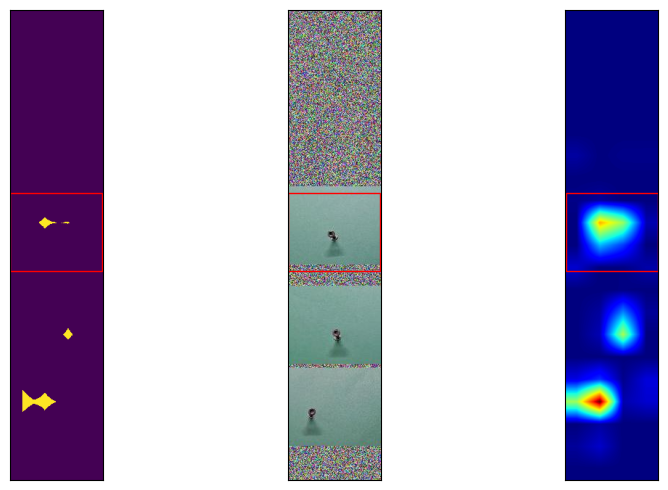

12 1500


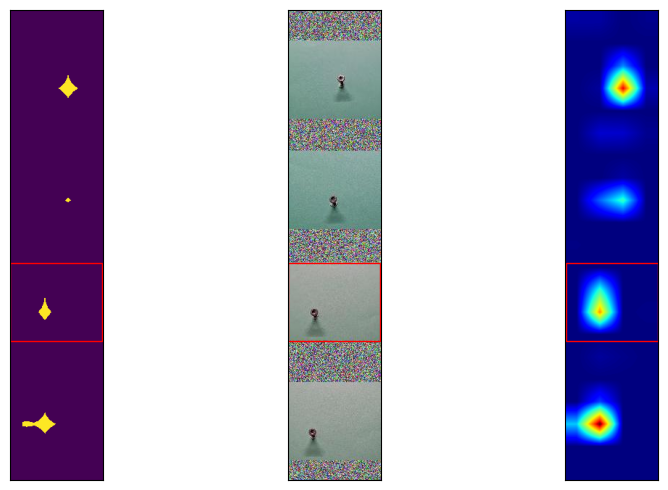

./data/temp/wheels_three/scale_1/ gray
12 154


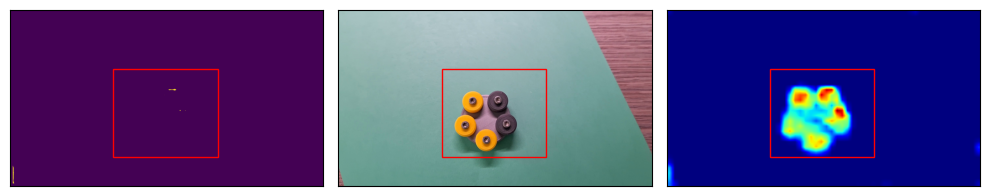

12 173


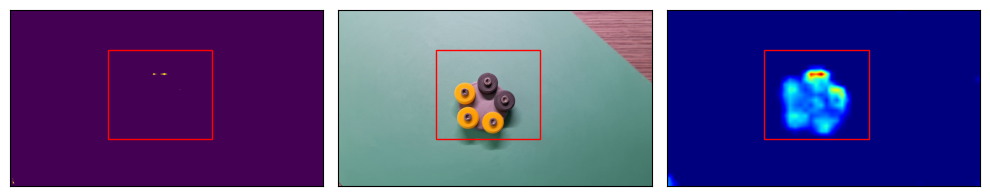

./data/temp/wheels_two/scale_1/ yellow_marked
12 182


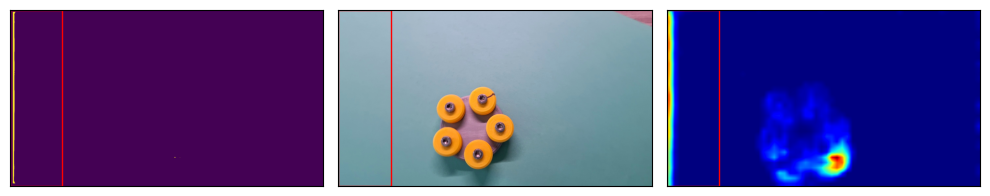

12 185


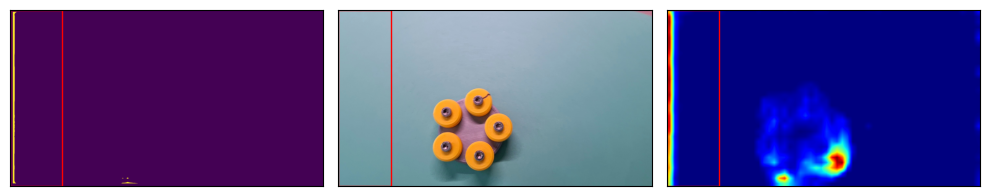

12 211


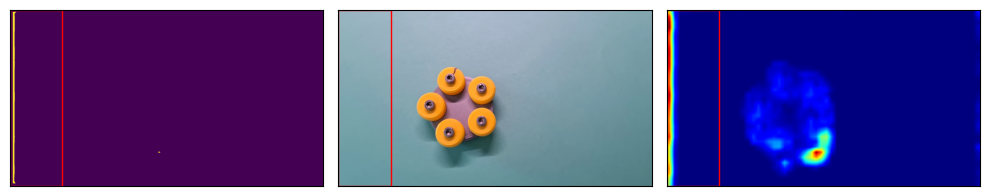

./data/temp/coins/scale_0.2/ coin_3
12 2


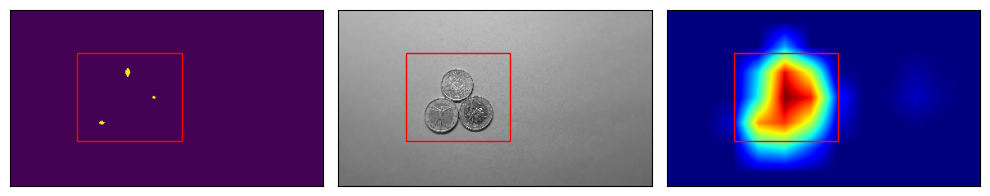

12 20


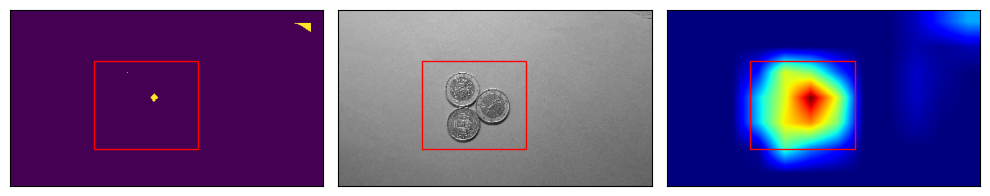

12 21


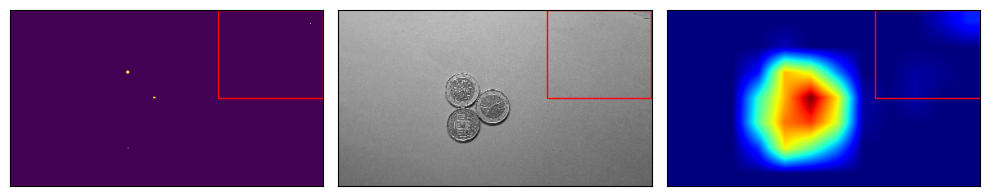

12 5


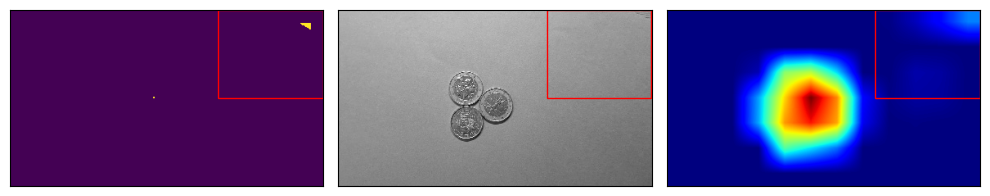

12 14


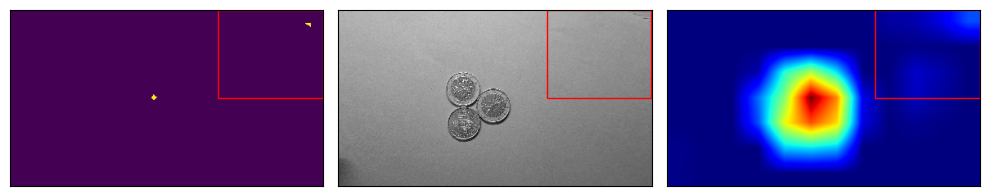

12 58


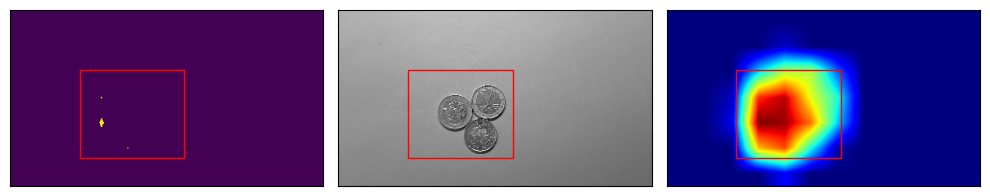

12 65


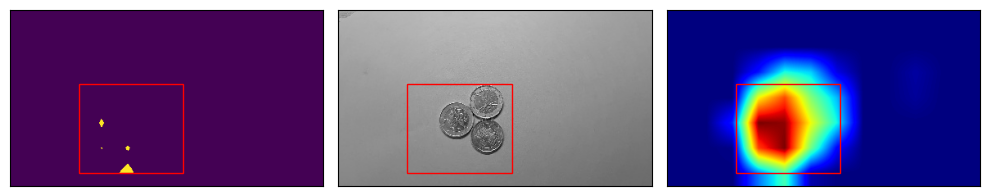

12 75


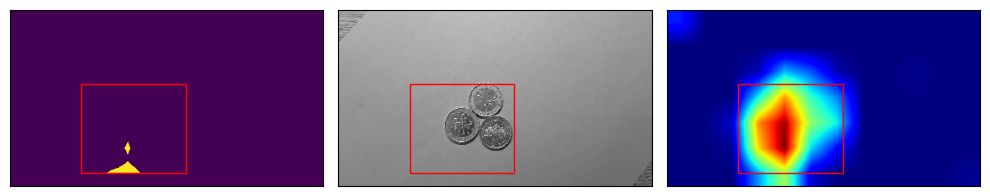

12 112


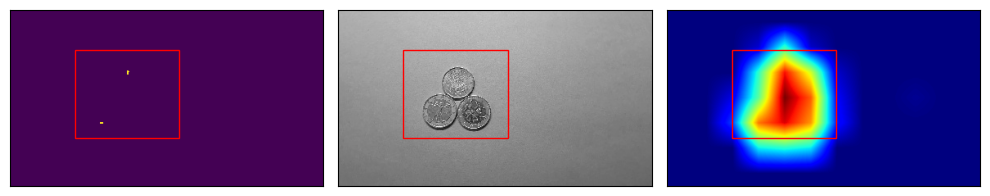

12 172


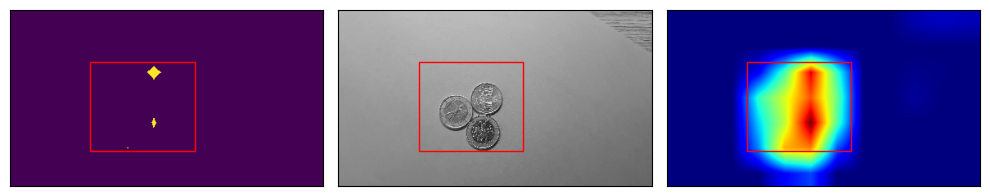

12 183


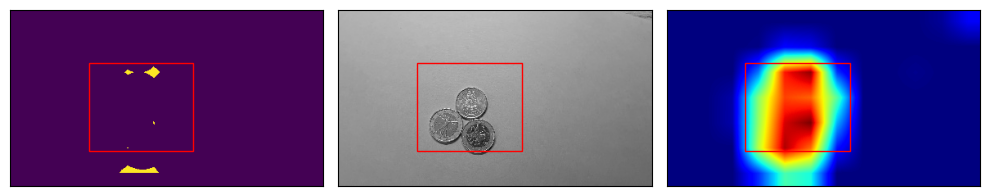

12 194


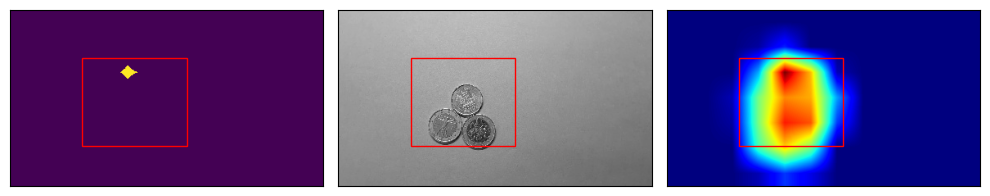

12 198


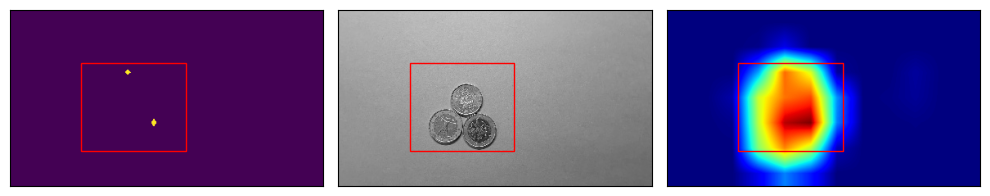

12 23


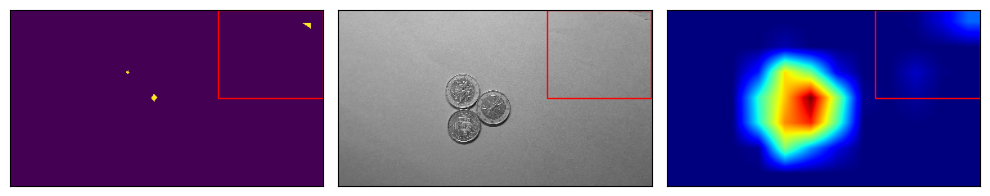

12 34


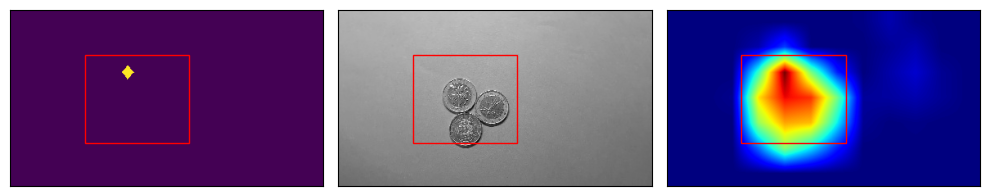

12 69


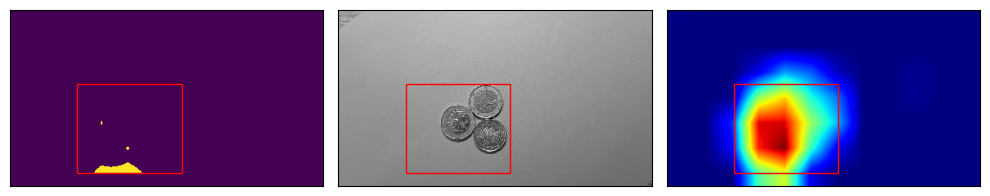

12 81


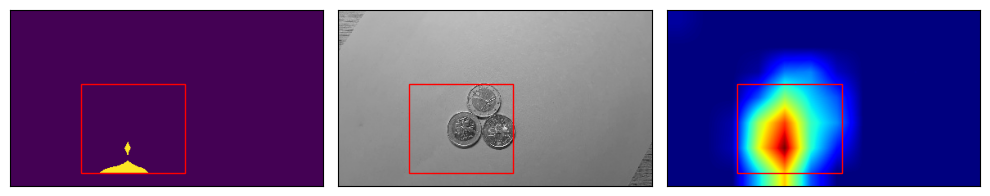

12 106


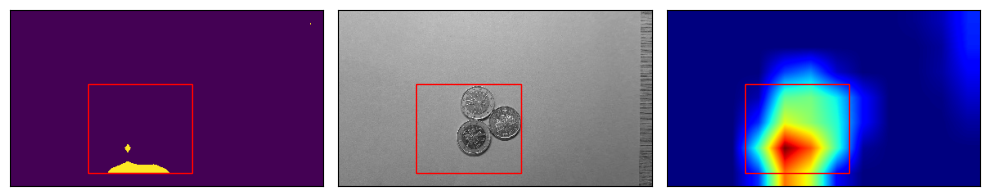

12 168


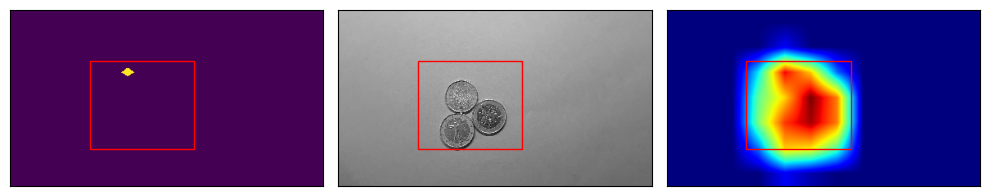

12 190


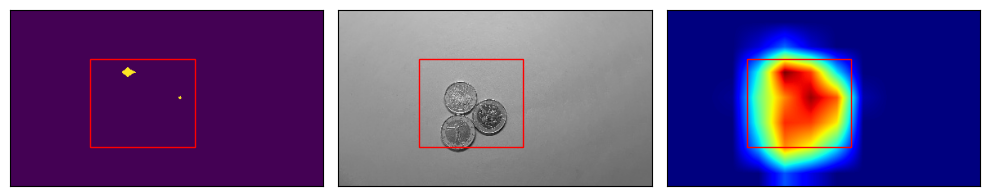

12 203


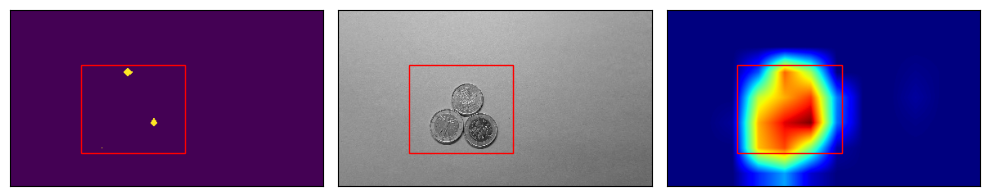

./data/temp/screwdriver/scale_1/ assembly
12 264


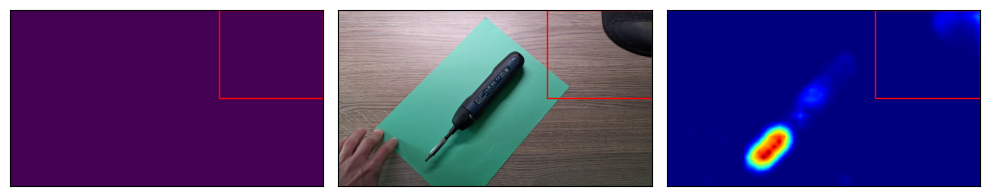

./data/temp/screwdriver/scale_1/ bit
12 329


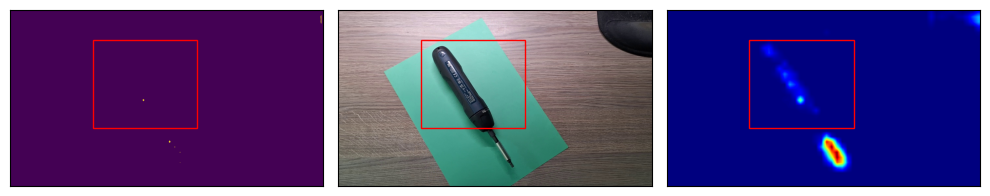

12 331


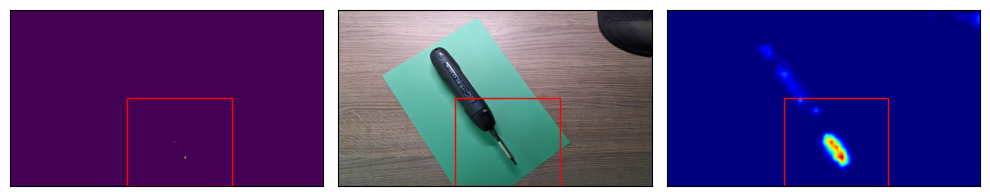

12 344


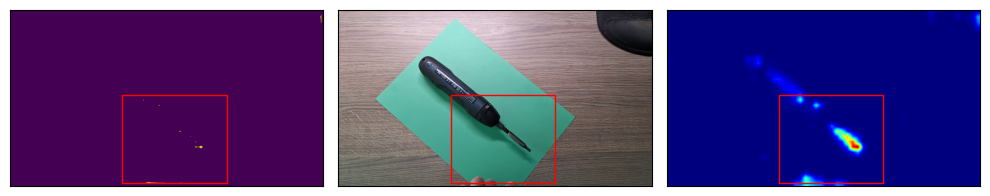

12 336


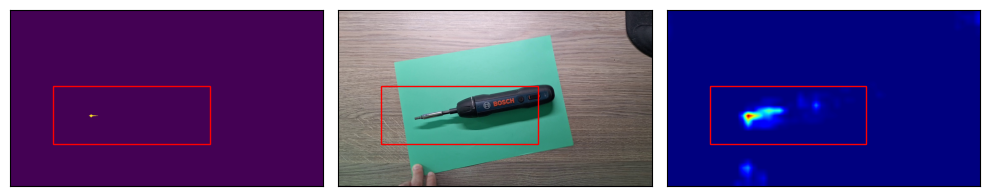

12 345


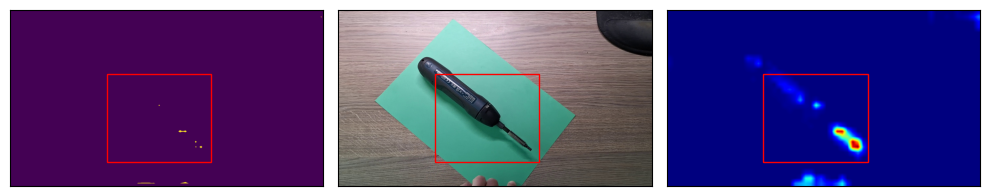

12 356


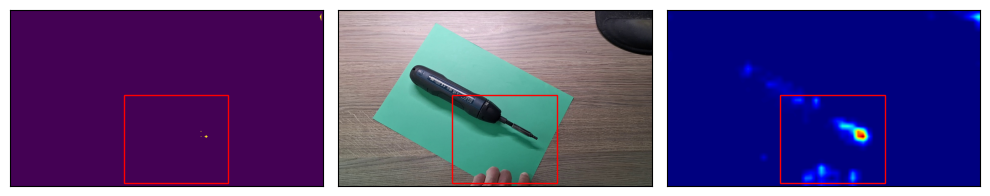

./data/temp/screwdriver/scale_0.35/ screwdriver
12 936


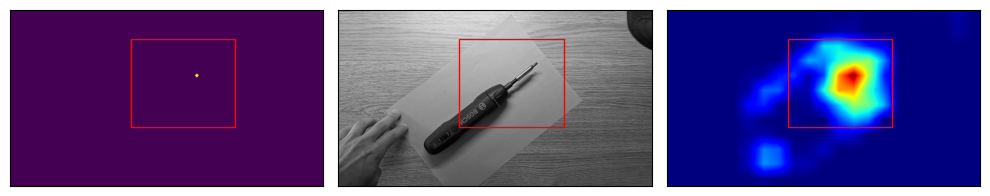

./data/temp/screwdriver/scale_0.35/ assembly
12 96


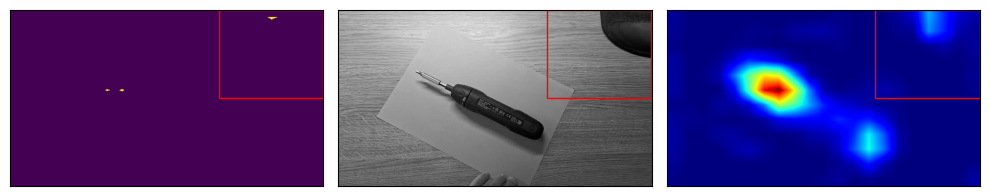

12 127


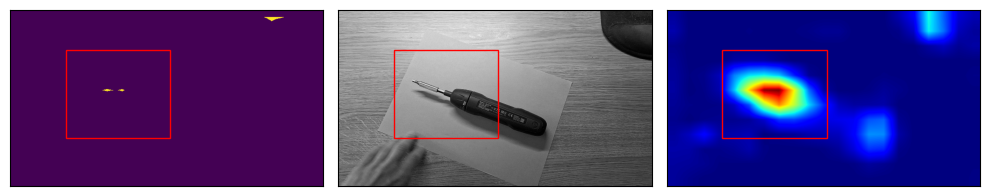

In [ ]:
tests = []
#tests.append(['./data/temp/wheels_five/scale_1/', 'yellow', 264])
#tests.append(["./data/temp/wheels_five/scale_1/", "black", [7, 17, 25, 171, 180, 191]])
#tests.append(["./data/temp/wheels_five/scale_1/", "red", [250]])
#tests.append(["./data/temp/wheels_five/scale_0.2/", "screw", [12]])
#tests.append(['./data/temp/wheels_five/scale_0.2/', 'black', [181, 193, 199, ]])
#tests.append(['./data/temp/wheels_three/scale_0.15/', 'screw', [186]])
#tests.append(["./data/temp/wheels_three/scale_1/", "base", [24,46,41,35,74,68,113,101,146,221]])
tests.append(["./data/temp/wheels_three/scale_1/", "gray", [154,173]])
#tests.append(["./data/temp/wheels_three/scale_1/", "screw", [42,49,]])
#tests.append(['./data/temp/wheels_three/scale_1/', 'yellow', [260,281, 292, 308]])
#tests.append(["./data/temp/wheels_two/scale_0.17/", "assembly", [60, 80, 297, 77]])
#tests.append(["./data/temp/wheels_two/scale_1/", "assembly", [40, 139, 164, 275, 309]])
#tests.append(["./data/temp/wheels_two/scale_1/", "screw", [30]])
tests.append(["./data/temp/wheels_two/scale_1/", "yellow_marked", [182,185,211]])
#tests.append(['./data/temp/coins/scale_0.2/', 'assembly', [1, 100,259,46,123, 13, 131]])
#tests.append(['./data/temp/coins/scale_0.2/', 'coin_1', [96, 99, 103, 104, 105,107, 131, 134, 217, 221, 241, 251, 258, 271, 240, 75, 93, ]])
#tests.append(['./data/temp/coins/scale_0.2/', 'coin_2', [48, 51, 65, 78, 83, 89, 95, 106, 214, 233, 58, 62, 64, 72, 81 , 84, 127, 132,174, 187, 194,200]])
tests.append(['./data/temp/coins/scale_0.2/', 'coin_3', [2, 20, 21,5, 14, 58, 65, 75, 112, 172, 183, 194, 198, 23, 34, 69,81, 106,168, 190,203 ]])
#tests.append(['./data/temp/coins/scale_1/', 'assembly', [9,10,271]])
#tests.append(['./data/temp/coins/scale_1/', 'coin_1', [69, 185, 194,205,30,38,201, 209,215,225,223,224]])
#tests.append(['./data/temp/coins/scale_1/', 'coin_2', [69, 185, 194,205,30,38,201, 209,215,225,223,224]])
#tests.append(["./data/temp/coins/scale_1/", "coin_3", [150, 151, 152]])
tests.append(['./data/temp/screwdriver/scale_1/', 'assembly', 264])
tests.append(["./data/temp/screwdriver/scale_1/","bit", [329,331,344, 336,345,356], ])
#tests.append(['./data/temp/screwdriver/scale_1/', 'holder', [2,18,46,285,309,197,320,272, 363, 14,40,57,113,252,379,394,277,366]])
#tests.append(["./data/temp/screwdriver/scale_1/", "screwdriver", [708,724,725,726] ])
tests.append(["./data/temp/screwdriver/scale_0.35/", "screwdriver", 936])
tests.append(["./data/temp/screwdriver/scale_0.35/", "assembly", [96,127]])

for i in [12]:
    for tst in tests:
        print(tst[0], tst[1])
        if type(tst[2]) != list:
            tst[2] = [tst[2]]        
        real_files = None
        if len(tst) > 3:
            real_files = tst[3]
        for pic in tst[2]:
            print(i, pic)
            gradcam(tst[0], tst[1], i, pic, to_show=2,real_files=real_files)

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM,  FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchvision.transforms.v2 as transforms
import random
import matplotlib.patches as patches

def gradcam_imgs(path, l_idx):
    print('Layer:', l_idx)
    client = MlflowClient()
    
    img_shape = Trainer.get_img_shape(f'{path}/assembly')
    transform = transforms.Compose([
                                    transforms.ToImage(),
                                    transforms.ToDtype(torch.float32, scale=True),
                                    transforms.Normalize([0.5]*img_shape[0], [0.5]*img_shape[0]) 
                                    ])
    print('Path:', path)
    ds = CustomImageFolder(path, transform=transform)
    to_pil = transforms.ToPILImage()
    dest_path = f'D:/gradcam_imgs/{l_idx}/{path.replace('./data/temp/', '')}'
    
    for part in ds.classes:        
        part_ds = Subset(ds, [i for i, target in enumerate(ds.targets) if target == ds.class_to_idx[part]])

        model_name = path.replace('/', '_') + '_' + part
        #print(model_name)
        model_version = client.search_model_versions(f'name="{model_name}"')[0].version        
        model = mlflow.pytorch.load_model(f'models:/{model_name}/{model_version}').to('cpu') 
        model.eval()
        
        rejected = 0
        os.makedirs(f'{dest_path}/{part}')
        
        target_layers = [model.layers.features[l_idx]]        
            
        cam = GradCAMPlusPlus(model=model, target_layers=target_layers)  
        targets = [ClassifierOutputTarget(0)]

        part_dl = DataLoader(part_ds, batch_size=512)

        for batch in part_dl:
            input_tensor = batch[:][0]#.unsqueeze(0) 
            
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)

            for i in range(len(part_ds)):
                
                grayscale_cam = grayscale_cams[0, :]  
            
                pil_image = to_pil(grayscale_cam)

                img_path = f'{dest_path}/{part}'
                
                if img_shape[0] == 1:
                    pil_image = pil_image.convert("L")
                
                pil_image.save(f'{img_path}/{i}.jpg')

        print(part, '\t', len(part_ds))

In [ ]:
for layer in [12]:
    for path in [
        "./data/temp/coins/scale_1/",
        "./data/temp/coins/scale_0.2/",
        "./data/temp/puzzle/scale_1/",
        "./data/temp/puzzle/scale_0.15/",
        "./data/temp/screwdriver/scale_1/",
        "./data/temp/screwdriver/scale_0.35/",
        "./data/temp/wheels_five/scale_1/",
        "./data/temp/wheels_five/scale_0.2/",
        "./data/temp/wheels_three/scale_1/",
        "./data/temp/wheels_three/scale_0.15/",
        "./data/temp/wheels_two/scale_1/",
        "./data/temp/wheels_two/scale_0.17/",
    ]:
        print(path, layer)
        gradcam_imgs(path, layer)

./data/temp/coins/scale_0.2/ 12
Layer: 12
Path: ./data/temp/coins/scale_0.2/
assembly 	 301
coin_1 	 281
coin_2 	 241
coin_3 	 238
./data/temp/puzzle/scale_1/ 12
Layer: 12
Path: ./data/temp/puzzle/scale_1/


AttributeError: 'Sequential' object has no attribute 'features'

In [11]:
from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    FullGrad,
)
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchvision.transforms.v2 as transforms
import random
import matplotlib.patches as patches
from random import Random


def check_imgs(path):
    stats = []
    client = MlflowClient()
    rand = Random()
    for layer in os.listdir(path):
        #print("LAYER:" + layer)
        for assembly in os.listdir(f"{path}/{layer}"):
            #print("\tASSEMBLY:", assembly)
            for scale in os.listdir(f"{path}/{layer}/{assembly}"):
                #print("\t\tSCALE:", scale)

                total_size_errors = 0
                total_errors = 0
                total_conf_errors = 0

                img_shape = Trainer.get_img_shape(
                    f"./data/temp/{assembly}/{scale}/assembly"
                )
                transform = transforms.Compose(
                    [
                        transforms.ToImage(),
                        transforms.ToDtype(torch.float32, scale=True),
                        transforms.Normalize(
                            [0.5] * img_shape[0], [0.5] * img_shape[0]
                        ),
                        #transforms.RandomCrop(size=(img_shape[1]*2, img_shape[2]*2), padding=(img_shape[2], img_shape[1]), padding_mode='edge')
                    ]
                )

                for part in os.listdir(f"{path}/{layer}/{assembly}/{scale}"):
                    print("\t\t\t" + part, end="\t")
                    ds = ImageFolder(
                        f"{path}/{layer}/{assembly}/{scale}/{part}",
                        transform=transform,
                        loader=CustomImageFolder.custom_pil_loader,
                    )
                    dataloader = DataLoader(ds)

                    model_name = "._data_temp_" + assembly + "_" + scale + "__" + part
                    # print(model_name)
                    model_version = client.search_model_versions(
                        f'name="{model_name}"'
                    )[0].version
                    print(
                        "model: ", client.search_model_versions(f'name="{model_name}"')[0].name,
                        "version: ", model_version,
                    )
                    model = mlflow.pytorch.load_model(
                        f"models:/{model_name}/{model_version}"
                    ).to("cpu")
                    model.eval()

                    size_errors = 0
                    errors = 0
                    conf_errors = 0

                    with torch.no_grad():
                        # for X, y in dataloader:
                        # for one in X:
                        for i in range(len(ds)):
                            one = ds[i][0]
                            if one.shape[1] > 3 and one.shape[2] > 3:
                                """
                                img = torch.rand(*img_shape)

                                c_start = rand.randrange(img.shape[1] - one.shape[1])
                                r_start = rand.randrange(img.shape[2] - one.shape[2])

                                img[
                                    :,
                                    c_start : c_start + one.shape[1],
                                    r_start : r_start + one.shape[2],
                                ] = one
                                
                                img = img * 0.5 + 0.5
                                img = img.clamp(0, 1)
                                
                                if img_shape[0] == 1:
                                    img = img.squeeze(0).numpy()  # shape (H, W)
                                    img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # shape (H, W, 3)
                                else:
                                    img = img.permute(1, 2, 0).numpy() 
                                plt.imshow(img) 
                                return          
                                """
                                pred = model(one.unsqueeze(0))
                                pred = torch.sigmoid(pred.flatten())
                                errors_buf = torch.sum(torch.round(pred) != 1).item()
                                #if errors_buf > 0:
                                    #print(ds.samples[i])
                                errors += errors_buf
                                pred[(pred < 0.75) & (pred > 0.25)] = -1
                                conf_errors += torch.sum(torch.round(pred) != 1).item()
                            else:
                                size_errors += 1

                        print(
                            errors,
                            "\t",
                            conf_errors,
                            "\t",
                            size_errors,
                            "\t",
                            len(dataloader),
                        )
                        total_size_errors += size_errors
                        total_errors += errors
                        total_conf_errors += conf_errors

                stats.append(
                    [f"{path}/{layer}/{assembly}/{scale}",
                     "\t",
                    total_errors,
                    "\t",
                    total_conf_errors,
                    "\t",
                    total_size_errors]
                )
        for s in stats:
            print(*s)

In [12]:
# after validation
import training_v1

check_imgs(r"D:/layer_imgs")

			assembly	model:  ._data_temp_coins_scale_0.2__assembly version:  16
1 	 103 	 0 	 301
			coin_1	model:  ._data_temp_coins_scale_0.2__coin_1 version:  14
0 	 0 	 0 	 281
			coin_2	model:  ._data_temp_coins_scale_0.2__coin_2 version:  14
0 	 1 	 0 	 241
			coin_3	model:  ._data_temp_coins_scale_0.2__coin_3 version:  14
0 	 1 	 0 	 238
			assembly	model:  ._data_temp_coins_scale_1__assembly version:  3
0 	 0 	 0 	 297
			coin_1	model:  ._data_temp_coins_scale_1__coin_1 version:  3
28 	 76 	 0 	 277
			coin_2	model:  ._data_temp_coins_scale_1__coin_2 version:  3
2 	 13 	 0 	 233
			coin_3	model:  ._data_temp_coins_scale_1__coin_3 version:  3
59 	 99 	 0 	 236
			assembly	model:  ._data_temp_puzzle_scale_0.15__assembly version:  3
0 	 0 	 0 	 415
			segment_1	model:  ._data_temp_puzzle_scale_0.15__segment_1 version:  3
368 	 368 	 0 	 368
			segment_2	model:  ._data_temp_puzzle_scale_0.15__segment_2 version:  3
428 	 435 	 0 	 439
			assembly	model:  ._data_temp_puzzle_scale_1__assembly 

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM,  FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import torchvision.transforms.v2 as transforms
import random
import matplotlib.patches as patches

def gradcam_imgs_aspcet(path, l_idx):
    print('Layer:', l_idx)
    client = MlflowClient()
    
    img_shape = Trainer.get_img_shape(f'{path}/assembly')
    transform = transforms.Compose([
                                    transforms.ToImage(),
                                    transforms.ToDtype(torch.float32, scale=True),
                                    transforms.Normalize([0.5]*img_shape[0], [0.5]*img_shape[0]) 
                                    ])
    print('Path:', path)
    ds = CustomImageFolder(path, transform=transform)
    to_pil = transforms.ToPILImage()
    dest_path = f'D:/layer_imgs_cv_filter/{l_idx}/{path.replace('./data/temp/', '')}'
    
    for part in ds.classes:        
        part_ds = Subset(ds, [i for i, target in enumerate(ds.targets) if target == ds.class_to_idx[part]])

        model_name = path.replace('/', '_') + '_' + part
        #print(model_name)
        model_version = client.search_model_versions(f'name="{model_name}"')[0].version        
        model = mlflow.pytorch.load_model(f'models:/{model_name}/{model_version}').to('cpu') 
        model.eval()
        
        img_aspects = []
        rejected = 0

        for i in range(len(part_ds)):
            input_tensor = part_ds[i][0].unsqueeze(0)
            
            img = part_ds[i][0] * 0.5 + 0.5
            img = img.clamp(0, 1)
            
            if img_shape[0] == 1:
                img = img.squeeze(0).numpy()  # shape (H, W)
                img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  # shape (H, W, 3)
            else:
                img = img.permute(1, 2, 0).numpy()    
            
            target_layers = [model.layers[l_idx]]
            cam = GradCAMPlusPlus(model=model, target_layers=target_layers)  
            targets = [ClassifierOutputTarget(0)]
            
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
            grayscale_cam = grayscale_cam[0, :]  
            
            top, bottom, left, right, grayscale_cam = get_boundary_box(grayscale_cam, 6) 

            if not (bottom - top < 3 or right - left < 3):
                with torch.no_grad():   
                                               
                    input_tensor[0, :, : top, :] = 0  # no negative slicing :(
                    input_tensor[0, :, bottom:, :] = 0
                    input_tensor[0, :, :, :left] = 0
                    input_tensor[0, :, :, right:] = 0
                    
                    pred = model(input_tensor)
                    pred = torch.sigmoid(pred.flatten())

                if pred.item() <= 0.5:
                    rejected += 1
                    mark='rejected_'
                else:
                    mark=''
            else:
                rejected += 1
                mark='rejected_'
            pil_image = to_pil(img[top:bottom, left:right])

            img_aspect = f'{img_shape[1]//(bottom-top)}_{img_shape[2]//(right-left)}'
            img_path = f'{dest_path}/{part}/{img_aspect}'

            if not img_aspect in img_aspects:
                img_aspects.append(img_aspect)
                os.makedirs(img_path)
            
            if img_shape[0] == 1:
                pil_image = pil_image.convert("L")
            
            pil_image.save(f'{img_path}/{mark}{i}.jpg')

        print(part, '\tRejected:', rejected, 'of', len(part_ds))